# Project 61

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/data_loader/PeMS-M.zip"
data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
data_dir = data_dir.rstrip(".zip")

route_distances = pd.read_csv(
    os.path.join(data_dir, "W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(os.path.join(data_dir, "V_228.csv"), header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")


6144000/6129354 [==============================] - 19s 3us/step
route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [4]:
sample_routes = [
    0, 
    1, 
    4, 
    7, 
    8, 
    11, 
    15, 
    108, 
    109, 
    114, 
    115, 
    118, 
    120, 
    123, 
    124, 
    126, 
    127, 
    129, 
    130, 
    132, 
    133, 
    136, 
    139, 
    144, 
    147, 
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


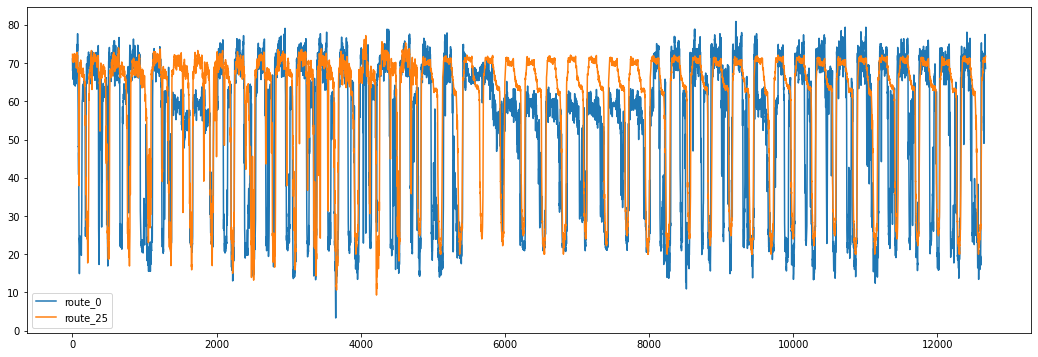

In [5]:
plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

Text(0, 0.5, 'road number')

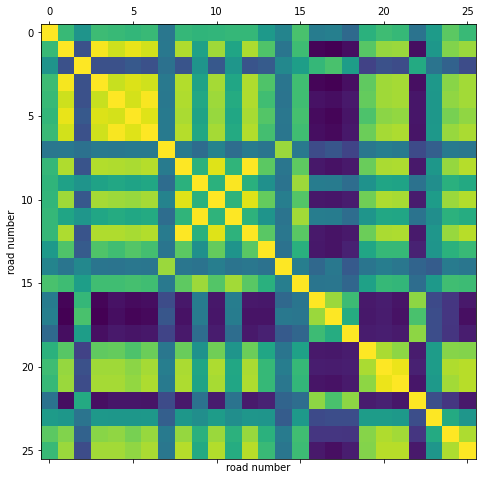

In [6]:
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")

In [7]:
train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    num_time_steps = data_array.shape[0]
    num_train, num_val = (int(num_time_steps * train_size), int(num_time_steps * val_size))
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)
    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val):] - mean) / std
    return train_array, val_array, test_array

In [8]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)
print(f"train set size: {train_array.shape}")
print(f"Validatin set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
Validatin set size: (2534, 26)
test set size: (3802, 26)


In [9]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

def create_tf_dataset(data_array: np.ndarray, input_sequence_length: int, forecast_horizon: int, 
                      batch_size: int=128, shuffle=True, multi_horizon=True):
    inputs = timeseries_dataset_from_array(np.expand_dims(data_array[:-forecast_horizon], axis=-1),
                                          None, sequence_length=input_sequence_length, shuffle=False,
                                          batch_size=batch_size)
    target_offset = (input_sequence_length if multi_horizon else input_sequence_length + forecast_horizon - 1)
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(data_array[target_offset:], None, sequence_length=target_seq_length, 
                                           shuffle=False, batch_size=batch_size)
    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset.shuffle(100)
    return dataset.prefetch(16).cache()
train_dataset, val_dataset = (create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
                             for data_array in [train_array, val_array])
test_dataset = create_tf_dataset(test_array, input_sequence_length, forecast_horizon, 
                                 batch_size=test_array.shape[0], shuffle=False, multi_horizon=multi_horizon)

In [10]:
def compute_adjacency_matrix(route_distances: np.ndarray, sigma2:float, epsilon: float):
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (route_distances * route_distances, np.ones([num_routes, num_routes]) - np.identity(num_routes))
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [12]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices =np.where(adjacency_matrix == 1)
graph = GraphInfo(edges=(node_indices.tolist(), neighbor_indices.tolist()), num_nodes=adjacency_matrix.shape[0])
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 26, number of edges: 150


In [18]:
class GraphConv(layers.Layer):
    def __init__(self, in_feat, out_feat, graph_info: GraphInfo, aggregation_type="mean", 
                 combination_type="concat", activation: typing.Optional[str] = None, **kwargs):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(initial_value=keras.initializers.glorot_uniform()(shape=(in_feat, out_feat), 
                                                                        dtype="float32"), trainable=True)
        self.activation = layers.Activation(activation)
    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)
        if aggregation_func:
            return aggregation_func(neighbour_representations, self.graph_info.edges[0], 
                                    num_segments=self.graph_info.num_nodes)
        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")
    def compute_nodes_representation(self, features: tf.Tensor):
        return tf.matmul(features, self.weight)
    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)
    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}")
        return self.activation(h)
    def call(self, features: tf.Tensor):
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [19]:
class LSTMGC(layers.Layer):
    def __init__(self, in_feat, out_feat, lstm_units: int, input_seq_len: int, output_seq_len: int, 
                 graph_info: GraphInfo, graph_conv_params: typing.Optional[dict] = None, **kwargs):
        super().__init__(**kwargs)
        if graph_conv_params is None:
            graph_conv_params = {"aggregation_type":"mean", "combination_type":"concat", "activation":None}
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)
        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len
    def call(self, inputs):
        inputs = tf.transpose(inputs, [2, 0, 1, 3])
        gcn_out = self.graph_conv(inputs)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (shape[0], shape[1], shape[2], shape[3])
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(gcn_out)
        dense_output = self.dense(lstm_out)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(output, [1, 2, 0])

In [20]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None
}
st_gcn = LSTMGC(in_feat, out_feat, lstm_units, input_sequence_length, forecast_horizon, graph, graph_conv_params)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)
model = keras.models.Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0002), 
             loss = keras.losses.MeanSquaredError())
model.fit(train_dataset, validation_data = val_dataset, epochs=epochs, 
          callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
99/99 [==============================] - 23s 204ms/step - loss: 0.6519 - val_loss: 0.3501
Epoch 2/20
99/99 [==============================] - 19s 190ms/step - loss: 0.2693 - val_loss: 0.1969
Epoch 3/20
99/99 [==============================] - 19s 188ms/step - loss: 0.1719 - val_loss: 0.1352
Epoch 4/20
99/99 [==============================] - 19s 188ms/step - loss: 0.1316 - val_loss: 0.1063
Epoch 5/20
99/99 [==============================] - 18s 185ms/step - loss: 0.1098 - val_loss: 0.0941
Epoch 6/20
99/99 [==============================] - 18s 184ms/step - loss: 0.1003 - val_loss: 0.0874
Epoch 7/20
99/99 [==============================] - 18s 185ms/step - loss: 0.0951 - val_loss: 0.0829
Epoch 8/20
99/99 [==============================] - 18s 187ms/step - loss: 0.0917 - val_loss: 0.0804
Epoch 9/20
99/99 [==============================] - 18s 186ms/step - loss: 0.0892 - val_loss: 0.0788
Epoch 10/20
99/99 [==============================] - 18s 186ms/step - loss: 0.0874 - val_lo

naive MAE: 0.13472308593195767, model MAE: 1.010665723875257


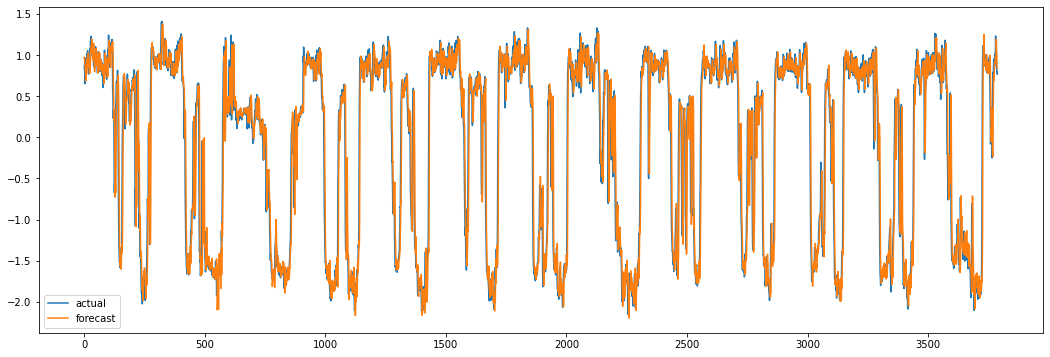

In [21]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(), 
                        np.square(y_pred[:, 0, :], - y[:, 0, :]).mean())
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")

# Project 62

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [23]:
from zipfile import ZipFile
import os

uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)


13582336/13568290 [==============================] - 16s 1us/step


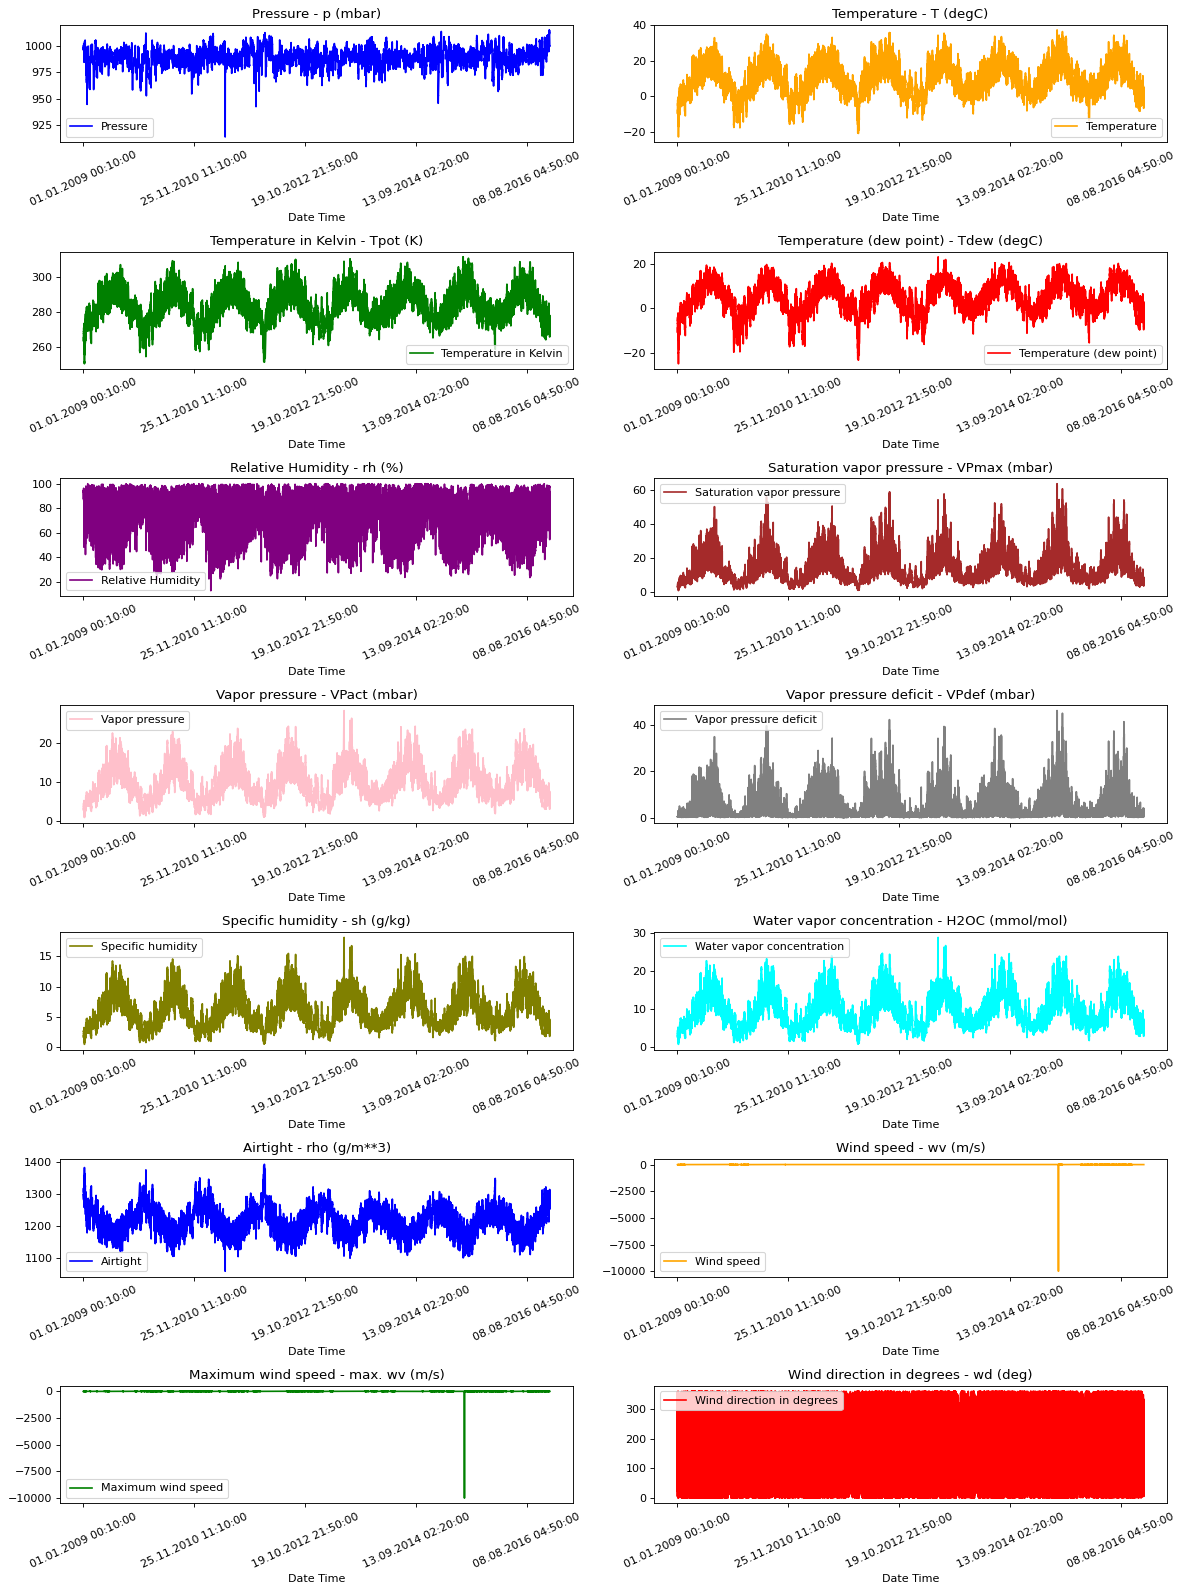

In [24]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k")
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(ax=axes[i // 2, i % 2], color=c, title="{} - {}".format(titles[i], key), rot=25)
        ax.legend([titles[i]])
    plt.tight_layout()
show_raw_visualization(df)

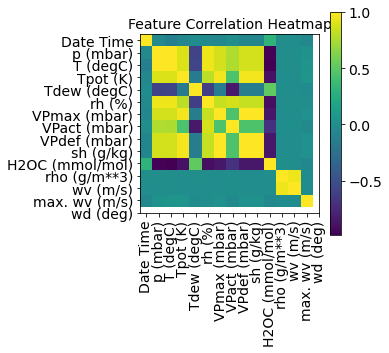

In [26]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
show_heatmap(df)

In [27]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6
past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [28]:
print("The selected parameters are: ", ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]))
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are:  Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [29]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]
sequence_length = int(past / step)

In [32]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(x_train, y_train, 
                                    sequence_length=sequence_length, sampling_rate=step, batch_size=batch_size)

In [34]:
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(x_val, y_val, sequence_length=sequence_length, 
                                                               sampling_rate=step, batch_size=batch_size)
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 120, 7)
Target shape: (256, 1)


In [35]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                5120      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(dataset_train, epochs=epochs, validation_data=dataset_val)

Epoch 1/10
1172/1172 [==============================] - 238s 200ms/step - loss: 0.1981 - val_loss: 0.1455
Epoch 2/10
1172/1172 [==============================] - 237s 202ms/step - loss: 0.1254 - val_loss: 0.1406
Epoch 3/10
1172/1172 [==============================] - 237s 202ms/step - loss: 0.1132 - val_loss: 0.1489
Epoch 4/10
1172/1172 [==============================] - 239s 204ms/step - loss: 0.1094 - val_loss: 0.1450
Epoch 5/10
1172/1172 [==============================] - 240s 205ms/step - loss: 0.1066 - val_loss: 0.1369
Epoch 6/10
1172/1172 [==============================] - 242s 207ms/step - loss: 0.1049 - val_loss: 0.1349
Epoch 7/10
1172/1172 [==============================] - 243s 207ms/step - loss: 0.1030 - val_loss: 0.1322
Epoch 8/10
1172/1172 [==============================] - 242s 206ms/step - loss: 0.1014 - val_loss: 0.1285
Epoch 9/10
1172/1172 [==============================] - 245s 209ms/step - loss: 0.0999 - val_loss: 0.1265
Epoch 10/10
1172/1172 [=======================

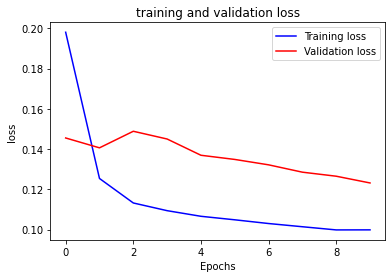

In [38]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.ylabel("loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
visualize_loss(history, "training and validation loss")

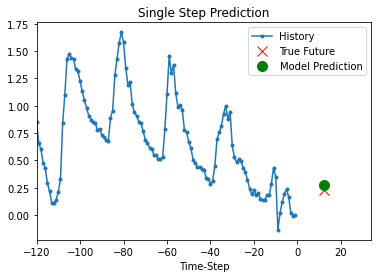

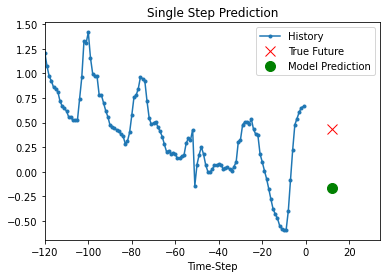

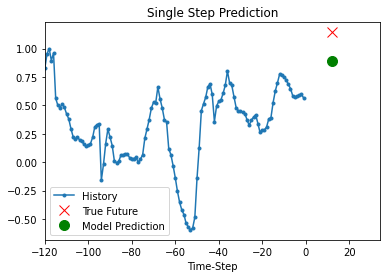

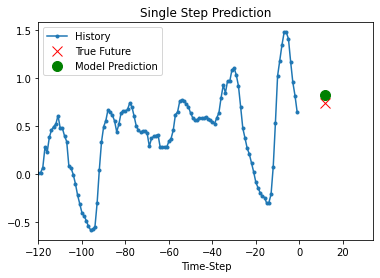

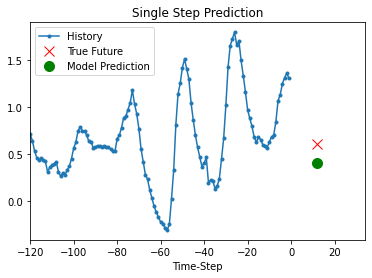

In [41]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(5):
    show_plot([x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]], 12, "Single Step Prediction")

# Project 63

In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display

In [47]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)


file_name                           normalized_transcription
0  LJ017-0099  Cook recovered this time; it was probably Palm...
1  LJ025-0156  with atmospheric air containing its ordinary m...
2  LJ031-0031  Despite his serious wounds, Governor Connally ...

In [48]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 11790
Size of the training set: 1310


In [50]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)
print(f"The vocabulary is : {char_to_num.get_vocabulary()}"
     f"(size = {char_to_num.vocabulary_size()})")

The vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '](size = 31)


In [56]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    mean = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - mean) / (stddevs + 1e-10)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectrogram, label

In [57]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [66]:
# fig = plt.figure(figsize=(8, 5))
# for batch in train_dataset.take(1):
#     spectrogram = batch[0][0].numpy()
#     spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
#     label = batch[1][0]
#     # Spectrogram
#     label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
#     ax = plt.subplot(2, 1, 1)
#     ax.imshow(spectrogram, vmax=1)
#     ax.set_title(label)
#     ax.axis("off")
#     # Wav
#     wav_file = list(df_train["file_name"])[0]
#     file = tf.io.read_file(wavs_path + wav_file + ".wav")
#     audio, _ = tf.audio.decode_wav(file)
#     audio = audio.numpy()
#     ax = plt.subplot(2, 1, 2)
#     plt.plot(audio)
#     ax.set_title("Signal Wave")
#     ax.set_xlim(0, len(audio))
#     display.display(display.Audio(np.transpose(audio), rate=16000))
# plt.show()

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [68]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False, 
                      name="conv_1")(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False, 
                     name="conv2")(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh", recurrent_activation="sigmoid", use_bias=True, 
                              return_sequences=True, reset_after=True, name=f"gru_{i}")
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}", merge_mode="concat")(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units*2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model
model = build_model(input_dim = fft_length // 2 + 1, output_dim=char_to_num.vocabulary_size(), rnn_units=512)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [69]:
epochs = 1
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)

NotFoundError: Graph execution error:

NewRandomAccessFile failed to Create/Open: C:\Users\jatin\.keras\datasets\LJSpeech-1.1/wavs/LJ017-0099.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_97941]

# Project 64

In [119]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [123]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [124]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 14, 14, 32)   320         ['input_30[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_4[0][0]']               
                                                                                                  
 flatten_2 (Flatten)            (None, 3136)         0           ['conv2d_5[0][0]']               
                                                                                            

In [126]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [132]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, 
                                                                                                reconstruction), 
                                                               axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss":self.total_loss_tracker.result(),
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "kl_loss":self.kl_loss_tracker.result(),
        }

In [133]:
(X_train, _), (X_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")/255
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 97s 174ms/step - loss: 264.3927 - reconstruction_loss: 215.0806 - kl_loss: 2.0599
Epoch 2/30
547/547 [==============================] - 96s 175ms/step - loss: 192.9850 - reconstruction_loss: 188.2827 - kl_loss: 3.1135
Epoch 3/30
547/547 [==============================] - 95s 174ms/step - loss: 187.3891 - reconstruction_loss: 182.9686 - kl_loss: 3.2916
Epoch 4/30
547/547 [==============================] - 96s 175ms/step - loss: 183.6868 - reconstruction_loss: 179.9801 - kl_loss: 3.4201
Epoch 5/30
547/547 [==============================] - 75s 137ms/step - loss: 181.9854 - reconstruction_loss: 177.9895 - kl_loss: 3.4991
Epoch 6/30
547/547 [==============================] - 67s 122ms/step - loss: 180.3757 - reconstruction_loss: 176.3237 - kl_loss: 3.5819
Epoch 7/30
547/547 [==============================] - 67s 122ms/step - loss: 179.0094 - reconstruction_loss: 174.9565 - kl_loss: 3.6316
Epoch 8/30
547/547 [============================

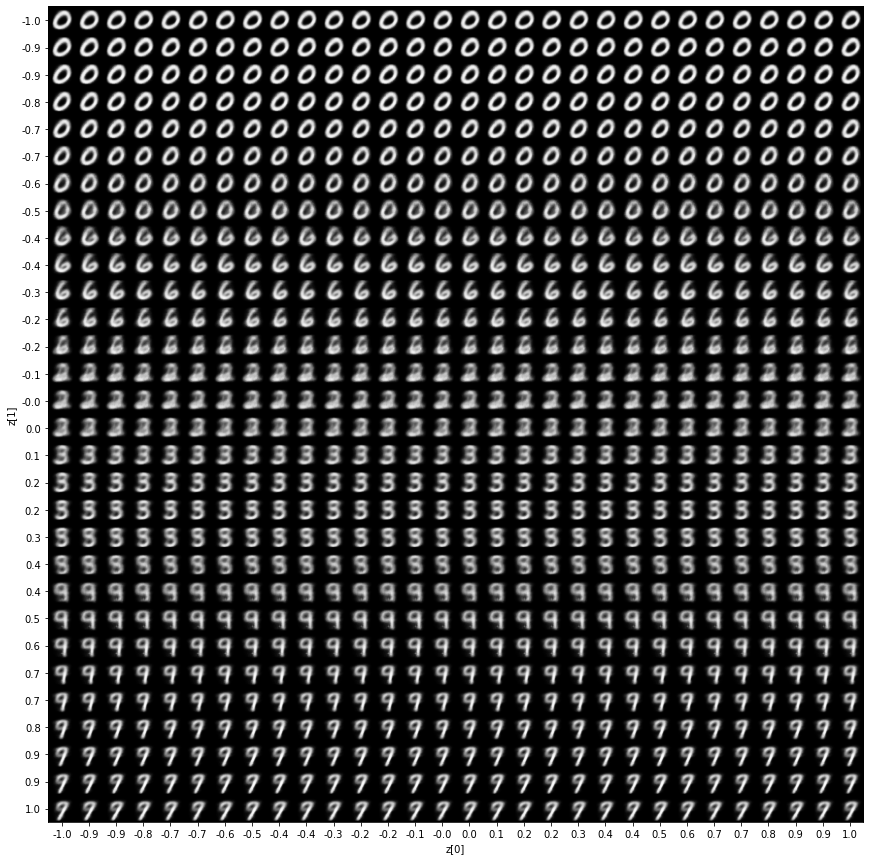

In [134]:
import matplotlib.pyplot as plt
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size] = digit
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(vae)

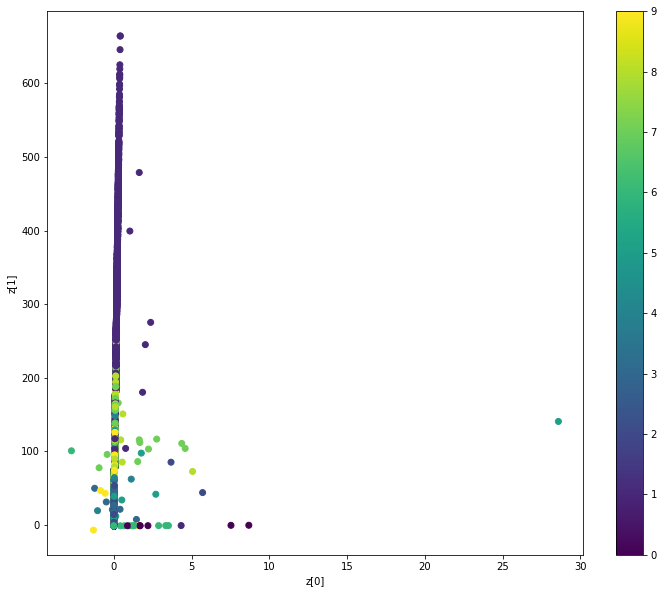

In [137]:
def plot_label_clusters(vae, data, labels):
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32")
plot_label_clusters(vae, x_train, y_train)

# project 65

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [140]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


In [2]:
dataset = keras.preprocessing.image_dataset_from_directory("celeba_gan", label_mode=None, image_size=(64, 64), 
                                                        batch_size=32)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


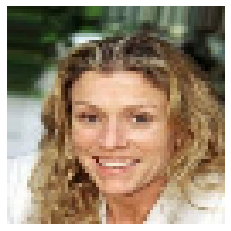

In [3]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [4]:
discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
], name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [5]:
latent_dim = 128
generator = keras.Sequential([
    keras.Input(shape=(latent_dim)),
    layers.Dense(8 * 8 * 128),
    layers.Reshape((8, 8, 128)),
    layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
], name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss":self.d_loss_metric.result(),
            "d_loss":self.g_loss_metric.result(),
        }

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random_normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        img = generated_images.numpy()
        plt.imshow(img)

In [8]:
epochs = 1
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(d_optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
           g_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
           loss_fn = keras.losses.BinaryCrossentropy())
gan.fit(dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)])

6332/6332 [==============================] - ETA: 0s - d_loss: 1.2189 

AttributeError: module 'tensorflow' has no attribute 'random_normal'

# Project 66

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [11]:
def conv_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), padding="same", use_bias=True, 
               use_bn=False, use_dropout=False, drop_value=0.5):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation=(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(x, 64, kernel_size=(5, 5), strides=(2, 2), use_bn=False, use_bias=True, 
                   activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)
    x = conv_block(x, 128, kernel_size=(5, 5), strides=(2, 2), use_bn=False, activation=layers.LeakyReLU(0.2), 
                  use_bias=True, use_dropout=True, drop_value=0.3)
    x = conv_block(x, 256, kernel_size=(5, 5), strides=(2, 2), use_bn=False, activation=layers.LeakyReLU(0.2), 
                  use_bias=True, use_dropout=True, drop_value=0.3)
    x = conv_block(x, 512, kernel_size=(5, 5), strides=(2, 2), use_bn=False, activation=layers.LeakyReLU(0.2), 
                  use_bias=True, use_dropout=False, drop_value=0.3)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)
    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 32, 32, 1)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        1664      
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         819456    
                                                     

In [13]:
def upsample_block(x, filters, activation, kernel_size=(3, 3), strides=(1, 1), up_size=(2, 2), padding="same", 
                  use_bn=False, use_bias=True, use_dropout=False, drop_value=0.3):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", 
                      use_dropout=False)
    x = upsample_block(x, 64, layers.LeakyReLU(0.2), strides=(1, 1), use_bias=False, use_bn=True, padding="same", 
                      use_dropout=False)
    x = upsample_block(x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True)
    x = layers.Cropping2D((2, 2))(x)
    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                       

In [18]:
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        self.discriminator=discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss":d_loss, "g_loss":g_loss}

In [19]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

epochs = 20
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

wgan = WGAN(discriminator=d_model, generator=g_model, latent_dim=noise_dim, discriminator_extra_steps=3)
wgan.compile(d_optimizer=discriminator_optimizer, g_optimizer=generator_optimizer, g_loss_fn=generator_loss, 
            d_loss_fn=discriminator_loss)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs)

Epoch 1/20
118/118 [==============================] - 7496s 63s/step - d_loss: -3.4272 - g_loss: -11.3255
Epoch 2/20
118/118 [==============================] - 6764s 57s/step - d_loss: -1.6122 - g_loss: -12.8446
Epoch 3/20
118/118 [==============================] - 6779s 57s/step - d_loss: -1.2554 - g_loss: -12.8533
Epoch 4/20
118/118 [==============================] - 6769s 57s/step - d_loss: -1.0218 - g_loss: -11.4639
Epoch 5/20
118/118 [==============================] - 6765s 57s/step - d_loss: -0.8148 - g_loss: -10.3864
Epoch 6/20
118/118 [==============================] - 6744s 57s/step - d_loss: -0.7491 - g_loss: -7.8389
Epoch 7/20
118/118 [==============================] - 6760s 57s/step - d_loss: -0.6168 - g_loss: -6.3006
Epoch 8/20
118/118 [==============================] - 6764s 57s/step - d_loss: -0.5743 - g_loss: -5.8408
Epoch 9/20
118/118 [==============================] - 6809s 58s/step - d_loss: -0.5685 - g_loss: -3.9950
Epoch 10/20
118/118 [=============================

In [20]:
batch_size = tf.shape(train_images)[0]
random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

In [22]:
image = wgan.generator.predict(random_latent_vectors)

# Project 67

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"

total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

950272/935806 [==============================] - 12s 13us/step


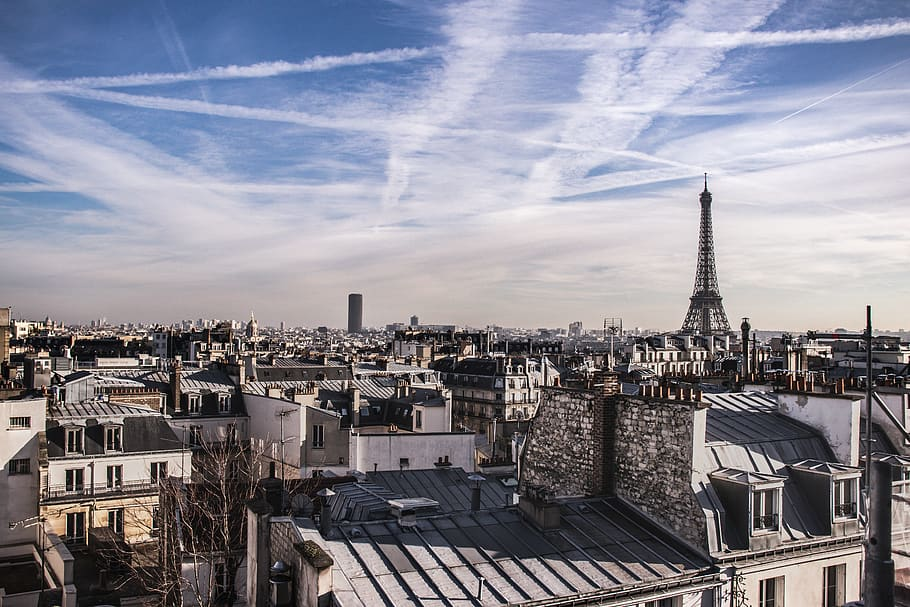

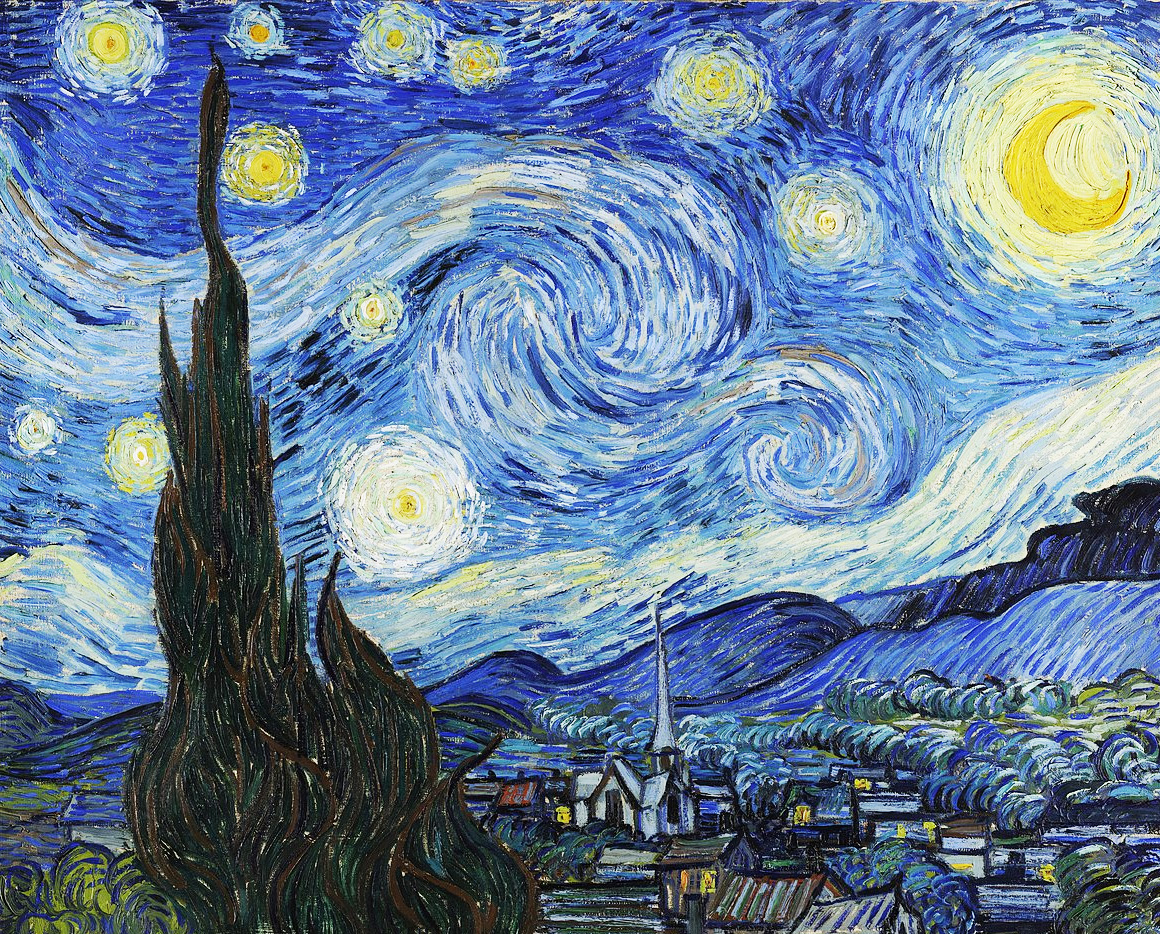

In [32]:
from IPython.display import Image, display
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [33]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [46]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [47]:
model = vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [48]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1"
]
content_layer_name = "block5_conv2"

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [49]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Iteration 100: loss=11024.22
Iteration 200: loss=8518.77
Iteration 300: loss=7573.88
Iteration 400: loss=7063.22
Iteration 500: loss=6734.23
Iteration 600: loss=6498.77
Iteration 700: loss=6319.53
Iteration 800: loss=6177.47
Iteration 900: loss=6061.05
Iteration 1000: loss=5963.64
Iteration 1100: loss=5880.72
Iteration 1200: loss=5809.32
Iteration 1300: loss=5747.32
Iteration 1400: loss=5692.94
Iteration 1500: loss=5644.73
Iteration 1600: loss=5601.60
Iteration 1700: loss=5562.97
Iteration 1800: loss=5528.05
Iteration 1900: loss=5496.49
Iteration 2000: loss=5467.82
Iteration 2100: loss=5441.71
Iteration 2200: loss=5417.85
Iteration 2300: loss=5395.97
Iteration 2400: loss=5375.82
Iteration 2500: loss=5357.26
Iteration 2600: loss=5340.10
Iteration 2700: loss=5324.23
Iteration 2800: loss=5309.52
Iteration 2900: loss=5295.86
Iteration 3000: loss=5283.14
Iteration 3100: loss=5271.30
Iteration 3200: loss=5260.27
Iteration 3300: loss=5249.95
Iteration 3400: loss=5240.29
Iteration 3500: loss=5

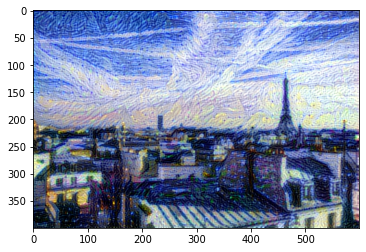

In [51]:
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, 
                decay_steps=100, decay_rate=0.96))
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f"%(i, loss))
        img = deprocess_image(combination_image.numpy())
        plt.imshow(img)

# Project 68

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("sky.jpg", "https://i.imgur.com/aGBdQyK.jpg")
result_prefix = "sky_dream"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 15.0


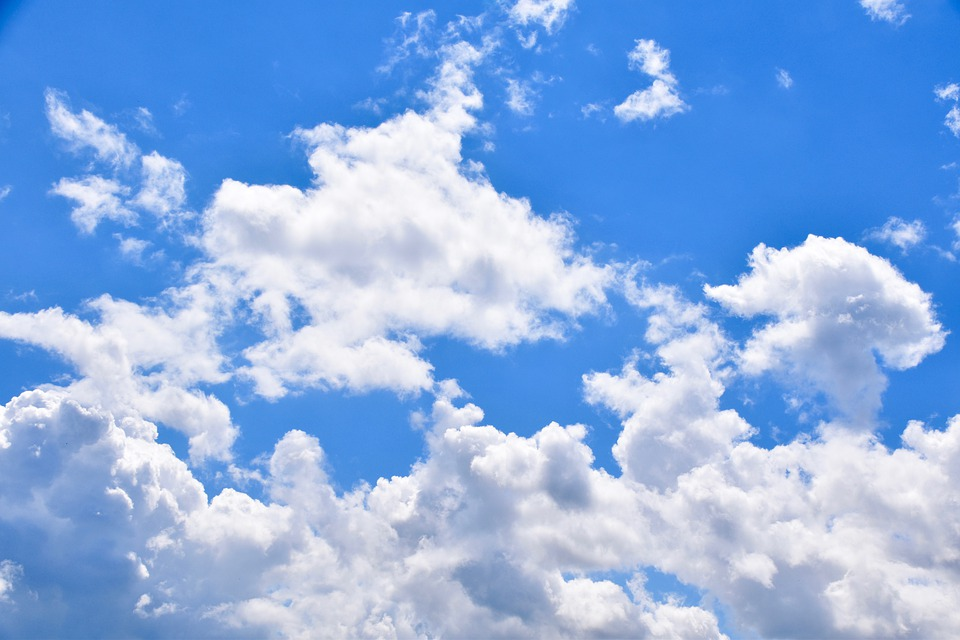

In [70]:
from IPython.display import Image, display
display(Image(base_image_path))

In [71]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


In [72]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [73]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss


In [74]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img


Processing octave 0 with shape (326, 489)
... Loss value at step 0: 0.45
... Loss value at step 1: 0.63
... Loss value at step 2: 0.91
... Loss value at step 3: 1.24
... Loss value at step 4: 1.57
... Loss value at step 5: 1.90
... Loss value at step 6: 2.20
... Loss value at step 7: 2.52
... Loss value at step 8: 2.82
... Loss value at step 9: 3.14
... Loss value at step 10: 3.41
... Loss value at step 11: 3.72
... Loss value at step 12: 3.97
... Loss value at step 13: 4.27
... Loss value at step 14: 4.50
... Loss value at step 15: 4.77
... Loss value at step 16: 5.05
... Loss value at step 17: 5.32
... Loss value at step 18: 5.57
... Loss value at step 19: 5.85
Processing octave 1 with shape (457, 685)
... Loss value at step 0: 1.12
... Loss value at step 1: 1.80
... Loss value at step 2: 2.38
... Loss value at step 3: 2.86
... Loss value at step 4: 3.32
... Loss value at step 5: 3.75
... Loss value at step 6: 4.18
... Loss value at step 7: 4.56
... Loss value at step 8: 4.93
... Los

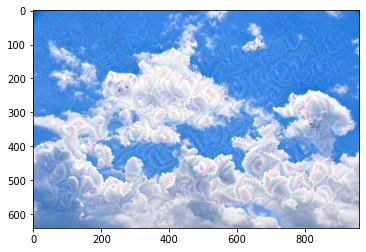

In [75]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s"%(i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)
plt.imshow(deprocess_image(img.numpy()))

# Project 69

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

In [8]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
shape of training labels: (70000, 10)


In [10]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


In [11]:
discriminator = keras.Sequential([
    keras.layers.InputLayer((28, 28, discriminator_in_channels)),
    layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.GlobalMaxPooling2D(),
    layers.Dense(1),
], name="discriminator")

generator = keras.Sequential([
    keras.layers.InputLayer((generator_in_channels,)),
    layers.Dense(7 * 7 * generator_in_channels),
    layers.LeakyReLU(alpha=0.2),
    layers.Reshape((7, 7, generator_in_channels)),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")
], name="generator")

In [18]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    def train_step(self, data):
        real_images, one_hot_labels = data
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(image_one_hot_labels, repeats=[image_size * image_size])
        image_one_hot_labels = tf.reshape(image_one_hot_labels, (-1, image_size, image_size, num_classes))
        
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        
        generated_images = self.generator(random_vector_labels)
        
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat([fake_image_and_labels, real_image_and_labels], axis=0)
        
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat([random_latent_vectors, one_hot_labels], axis=1)
        
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        
        return {
            "g_loss":self.gen_loss_tracker.result(),
            "d_loss":self.disc_loss_tracker.result(),
        }

In [19]:
cond_gan = ConditionalGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
cond_gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0003), 
                g_optimizer=keras.optimizers.Adam(learning_rate=0.0003), 
                loss_fn = keras.losses.BinaryCrossentropy(from_logits=True))
cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 [==============================] - 1592s 1s/step - g_loss: 1.5672 - d_loss: 0.4065
Epoch 2/20
1094/1094 [==============================] - 1382s 1s/step - g_loss: 1.3711 - d_loss: 0.4833
Epoch 3/20
1094/1094 [==============================] - 1284s 1s/step - g_loss: 1.8268 - d_loss: 0.3153
Epoch 4/20
1094/1094 [==============================] - 1291s 1s/step - g_loss: 2.6538 - d_loss: 0.1629
Epoch 5/20
1094/1094 [==============================] - 1302s 1s/step - g_loss: 1.0681 - d_loss: 0.6443
Epoch 6/20
1094/1094 [==============================] - 1302s 1s/step - g_loss: 1.0016 - d_loss: 0.6185
Epoch 7/20
1094/1094 [==============================] - 1303s 1s/step - g_loss: 0.9141 - d_loss: 0.6379
Epoch 8/20
1094/1094 [==============================] - 1308s 1s/step - g_loss: 0.8646 - d_loss: 0.6545
Epoch 9/20
1094/1094 [==============================] - 1306s 1s/step - g_loss: 0.8152 - d_loss: 0.6679
Epoch 10/20
1094/1094 [==============================] - 1307s 1

# Project 70

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

autotune = tf.data.AUTOTUNE

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [21]:
dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

orig_img_size = (286, 286)
input_img_size = (256, 256, 3)
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

def preprocess_train_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.resize(img, [*orig_img_size])
    img = tf.image.random_crop(img, size=[*input_img_size])
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling cycle_gan-trainA.tfrecord...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling cycle_gan-trainB.tfrecord...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling cycle_gan-testA.tfrecord...:   0%|          | 0/120 [00:00<?, ? examples/s]

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling cycle_gan-testB.tfrecord...:   0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to C:\Users\jatin\tensorflow_datasets\cycle_gan\horse2zebra\2.0.0. Subsequent calls will reuse this data.


In [22]:
train_horses = (train_horses.map(preprocess_train_image, num_parallel_calls=autotune)
               .cache()
               .shuffle(buffer_size)
               .batch(batch_size))
train_zebras = (train_zebras.map(preprocess_train_image, num_parallel_calls=autotune)
               .cache()
               .shuffle(buffer_size)
               .batch(batch_size))
test_horses = (test_horses.map(preprocess_test_image, num_parallel_calls=autotune)
              .cache()
              .shuffle(buffer_size)
              .batch(batch_size))
test_zebras = (test_zebras.map(preprocess_test_image, num_parallel_calls=autotune)
              .cache()
              .shuffle(buffer_size)
              .batch(batch_size))

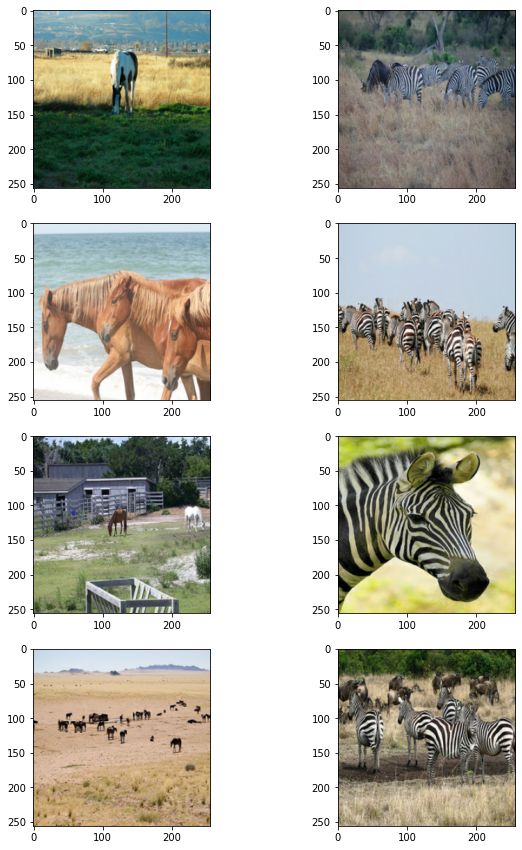

In [23]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_horses.take(4), train_zebras.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

In [43]:
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)
    def call(self, input_tensor, mask=None):
        padding_width, padding_height= self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0]
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(1, 1), 
                   padding="valid", gamma_initializer=gamma_init, use_bias=False):
    dim = x.shape[-1]
    input_tensor = x
    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, 
                     use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)
    
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, 
                     use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3), strides=(2, 2),
              gamma_initializer=gamma_init, use_bias=False, padding="same"):
    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, 
                      padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same", 
             kernel_initializer=kernel_init, gamma_initializer=gamma_init, use_bias=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, 
                               kernel_initializer=kernel_initializer, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [44]:
def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2, 
                        gamma_initializer=gamma_init, name=None):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)
    
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))
    
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))
    
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))
    
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
    
    model = keras.models.Model(img_input, x, name=name)
    return model

In [46]:
def get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", 
                      kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)
    
    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), 
                           strides=(2, 2))
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), 
                          strides=(1, 1))
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)
    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [49]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [51]:
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_horses, train_zebras)),
    epochs=1
)

 718/1067 [===================>..........] - ETA: 2:14:30 - G_loss: 4.6554 - F_loss: 4.2565 - D_X_loss: 0.1761 - D_Y_loss: 0.1122

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/generator_G/conv2d_123/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\jatin\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\jatin\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\jatin\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\jatin\anaconda3\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\jatin\anaconda3\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\jatin\anaconda3\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\jatin\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-51-4843e726fecf>", line 33, in <module>
      cycle_gan_model.fit(
    File "C:\Users\jatin\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jatin\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "<ipython-input-49-9de4445eb170>", line 108, in train_step
      grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
Node: 'gradient_tape/generator_G/conv2d_123/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[1,65536,3136] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/generator_G/conv2d_123/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_184425]

# Project 71

In [72]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import random
import io

In [73]:
path = keras.utils.get_file(
    "nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Corpus length:", len(text))

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


Corpus length: 600893
Total chars: 56
Number of sequences: 200285


<ipython-input-73-2203395575c3>:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
<ipython-input-73-2203395575c3>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.zeros((len(sentences), len(chars)), dtype=np.bool)


In [74]:
model = keras.Sequential([
    keras.Input(shape=(maxlen, len(chars))), 
    layers.LSTM(128),
    layers.Dense(len(chars), activation="softmax")
])
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [75]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [76]:
epochs = 40
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print()


1565/1565 [==============================] - 175s 109ms/step - loss: 1.9231

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: " impulse to self preservation or, more a"
...Generated:   self--such a the more the most the some to the some of the self--the some has the suppicions and the self--the self--the self--the self--the the self--least more the some of the self--the self-and the more in the self--the such a morting of the self--the self--the self--the self-and in the soll to the such a self--the self--the self-and the self--the strentance of the such a special the such such

...Diversity: 0.5
...Generating with seed: " impulse to self preservation or, more a"
...Generated:  nd that that is of not is mean the such men and charnotions and the self--the recertion of a the some of the sumple and that is constinct and intertian of the such connertian the something of the sees and not be the such and the genman and thought the so the self-every he wor of not in t

1565/1565 [==============================] - 202s 129ms/step - loss: 1.4063

Generating text after epoch: 4
...Diversity: 0.2
...Generating with seed: "son to neutralize the coarser: a finer f"
...Generated:  or the stricked the still man is the some is the individual into the extend that is all the self-expression and presure the striving to the strength of the stands the state the strives of the state of the state the stands to the man are the subjection that the striving and and intellectual intellectual still man is the still to the considing and intellectual single and simpless of the state and mo

...Diversity: 0.5
...Generating with seed: "son to neutralize the coarser: a finer f"
...Generated:  or the morality and morality and presenting the thought in the some presude in the state some is a great of the high principle the self-explaration the greatest of discipline of the artist hand of proidition of the possible the still modes of the secretly, the so from the moral stands to

1565/1565 [==============================] - 222s 142ms/step - loss: 1.3381

Generating text after epoch: 8
...Diversity: 0.2
...Generating with seed: "emns with impatient severity, as from a "
...Generated:  strength of the subject to the sense of the such a consequences and and a sense of the strength of the sense of the strength of the subject to the streat of the subject of the sense of the process and in the subject of the streat of the subject to the strean of the soul of the subject of the subject to the soul of the subject to a something the streat of the sense and and and and the contrast the 

...Diversity: 0.5
...Generating with seed: "emns with impatient severity, as from a "
...Generated:  the changed the superior the result and self-domain. they are because the related and the sume superior and senses, and a state and of the something that we has god been the subject to the whole for the soul and has are that a command to the sense are short, are not as the subject that i

1565/1565 [==============================] - 195s 125ms/step - loss: 1.3036

Generating text after epoch: 12
...Diversity: 0.2
...Generating with seed: "" and everything of necessity, their fee"
...Generated:  ling with a philosophy and contradiction of the philosophy and the sense and the most particism of the sense and the sense of the sense and a strength and the subject of the sense of the strength of the sense of the soul of the sense of the soul of the stage of the propossible and a strength of the sense of the streets of the self the sense of the possible and the sense of the proposition of the p

...Diversity: 0.5
...Generating with seed: "" and everything of necessity, their fee"
...Generated:  lings of dissimetion knowledge and contradiction of the propossible even the sear of the sense of matter of understand? is a strong the account controt which finally into the subject the philosophy of the other is the man is the free and perspnce of all and nowadays himself and gentity 

1565/1565 [==============================] - 214s 137ms/step - loss: 1.2820

Generating text after epoch: 16
...Diversity: 0.2
...Generating with seed: "ian in the ecstasies of the cross, the s"
...Generated:  tandard and conception of the subject of the subjection of the condition of the subjection of the present and and superior the subject, and an end as the moral case the sense and and as the surprised, and man and present and man and an an encourage of an end and the surprised to the subject: the laws to the conception of the subjection of the subject of the possess of the contrary and strength, wh

...Diversity: 0.5
...Generating with seed: "ian in the ecstasies of the cross, the s"
...Generated:  urprised and party and rocase and powerful in common and condition of the mand friends is in such an act and an encovers and society of the prophy in knowledge of the extent and devicidy to down respect to the worldy the decisely themself to capicity the more as the condition of an inst

1565/1565 [==============================] - 117s 75ms/step - loss: 1.2664

Generating text after epoch: 20
...Diversity: 0.2
...Generating with seed: "enience he thereby causes us.  126. a na"
...Generated:  ture of the standard of the consciousness, and in the strengh, which is such a decesses and such a philosophers, and a sensuaning of the love and such a such and so the profound the fact that is the artistic, and what is the sensation of the such a philosopher and such a philosopher and soul. the standard of the sensation of the experiences and such a demands of the primordual contrary, and a sens

...Diversity: 0.5
...Generating with seed: "enience he thereby causes us.  126. a na"
...Generated:  ture of experiences, and he does no longer reference of his strength, not in the pleases of the democratic that a really and appearance of the world of the man is aspect of the previrtions to see not to every concept--well to the most interprete and and rank that it is his paren has been

<ipython-input-75-ded0137f8096>:4: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


...Generated:  hand, is finally mindle whose, for one's goads tobead and al extremos distance. antimatimate.  23 ther sin--that the rouese motive that perpertorolity is some limit. i fathaunt of that that, is only wexcting what, curioal is since men whechfells to solom, lighteryens "nature" sissent, eassoss? as hunally, may be thinking enmyprocseosism welpary an, whether  essices of life. the subject: "it  means

1565/1565 [==============================] - 121s 77ms/step - loss: 1.2503

Generating text after epoch: 24
...Diversity: 0.2
...Generating with seed: " which was implied to an antique taste b"
...Generated:  y the state of the self-consisted to the state of the soul of the strive of the statesman how could be the more contempt, and the spirit of the former the sense and indication of the strength, and and the soul of the soul of the conceptions of the soul of the soul of the statesman of the soul of the superiority of the soul of the sense, in the contemption of the state of 

...Generated:  id forly--through religion, eognony when on whose eazity, are philosophy on men, responsible! you every ards things truth! as allout as now hypocols in an evojtvement. this oke hunc-gravationed in even be them; anablene to such a doctrothe; the speciale orgation of deceived; penisticror learn to anything for purpose, near the future, goobly-rist, the names for imhand to it" not arrs or has after w

1565/1565 [==============================] - 130s 83ms/step - loss: 1.2408

Generating text after epoch: 28
...Diversity: 0.2
...Generating with seed: "e philosophising artists) of dealing wit"
...Generated:  h the successe of the successe of the probably the present and the master of the success and the success in the such a stricted to the subject of the moral the light of the subjection of the most intellect of the subjection of the sense of the superion of the subject of the such a such a subjection, the success the such a such a south and the most decides of the successe 

...Generated:  chy.  282. better punime wished in given, this discurable inde, as menner aniveor, in the ssards of cruced, a hand, also of humsel-brar, of pointistry all the possible, with any typous too delfme. only like down my supkemstly. kniained decisely upaporihinally make an itly effection;   2120. upre the ny. "you the morebless,fjsibal bety really,"--was too strimate philosophy. itself as them, they for

1565/1565 [==============================] - 122s 78ms/step - loss: 1.2326

Generating text after epoch: 32
...Diversity: 0.2
...Generating with seed: "t without some danger--get an idea of wh"
...Generated:  ich the stals of the principory; and the special instinct of the state of the state of the more than the state of the sense, and as the more more of the sense, and the sense, and as the more for the more surprised the sense, and and and and the expression of the will to the sense of the probably the world and the stals, and and and the continue of the conclusion of the sa

...Generated:   they vary of the weaphy psy--much are also diquasion one afliings, to teochic romated. hitherton alto all knowledge task; unegesomest of myself you herelines nature, a ay, who reserbility as "ni vigousions"d--man, this soul.--and therefore, to very unexhertceishity here more that have laws, was for these clumsific and theorifat discleacely intobad against that tswvernety is so exceassly, withinli

1565/1565 [==============================] - 130s 83ms/step - loss: 1.2255

Generating text after epoch: 36
...Diversity: 0.2
...Generating with seed: "njure back some past era in the history "
...Generated:  and self-self-desires the strength of such a single the moral form of alled the present and success, and the bad and and and and all the strengthst and man and and an an all things, and the trained and self-self-desire and as the surpression of the subjection of the strengthst and the present and and the sensation of this principle and an almost man and an an are for the 

...Generated:  n into a man--this is the wmithignsely. as will-bsulin thee.  3e have have the ego grows   tills--all whole proashed psychologists, in such a slighter civilia of which experience in buvationing withnes--in their standard, taker sense appearanceing viws. the secrecce, thus other has ma! would nespers one still fain elose. underen: even aom, we, as an is nature for all wilcr!hele are --untilern!--to



# Project 72

In [78]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

In [79]:
num_classes = 10
input_shape = (28, 28, 1)
n_residual_blocks = 5

(x, _), (y, _) = keras.datasets.mnist.load_data()

data = np.concatenate((x, y), axis=0)
data = np.where(data < (0.33 * 256), 0, 1)
data = data.astype(np.float32)

In [84]:
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)
    def build(self, input_shape):
        self.conv.build(input_shape)
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[:kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=filters, kernel_size=1, activation="relu")
        self.pixel_conv = PixelConvLayer(mask_type="B", filters=filters // 2, kernel_size=3, activation="relu", 
                                        padding="same")
        self.conv2 = keras.layers.Conv2D(filters=filters, kernel_size=1, activation="relu")
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])

In [85]:
inputs = keras.Input(shape=input_shape)
x = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")(inputs)
for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)
for _ in range(2):
    x = PixelConvLayer(mask_type="B", filters=128, kernel_size=1, strides=1, activation="relu", padding="valid")(x)
out = keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid")(x)
pixel_cnn = keras.Model(inputs, out)
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="binary_crossentropy")
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 pixel_conv_layer_2 (PixelCo  (None, 28, 28, 128)      6400      
 nvLayer)                                                        
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      98624     
 lock)                                                       

In [86]:
pixel_cnn.fit(x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2)

Epoch 1/50
493/493 - 2334s - loss: 0.1141 - val_loss: 0.0943 - 2334s/epoch - 5s/step
Epoch 2/50
493/493 - 2271s - loss: 0.0907 - val_loss: 0.0903 - 2271s/epoch - 5s/step
Epoch 3/50
493/493 - 2268s - loss: 0.0887 - val_loss: 0.0885 - 2268s/epoch - 5s/step
Epoch 4/50
493/493 - 2263s - loss: 0.0877 - val_loss: 0.0870 - 2263s/epoch - 5s/step
Epoch 5/50
493/493 - 2285s - loss: 0.0870 - val_loss: 0.0880 - 2285s/epoch - 5s/step
Epoch 6/50
493/493 - 2275s - loss: 0.0864 - val_loss: 0.0883 - 2275s/epoch - 5s/step
Epoch 7/50
493/493 - 2274s - loss: 0.0859 - val_loss: 0.0864 - 2274s/epoch - 5s/step
Epoch 8/50
493/493 - 2278s - loss: 0.0855 - val_loss: 0.0865 - 2278s/epoch - 5s/step
Epoch 9/50
493/493 - 2272s - loss: 0.0853 - val_loss: 0.0853 - 2272s/epoch - 5s/step
Epoch 10/50
493/493 - 2272s - loss: 0.0851 - val_loss: 0.0855 - 2272s/epoch - 5s/step
Epoch 11/50
493/493 - 2275s - loss: 0.0848 - val_loss: 0.0854 - 2275s/epoch - 5s/step
Epoch 12/50
493/493 - 2266s - loss: 0.0845 - val_loss: 0.0863 -

# Project 73

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

In [8]:
output_dim = 256
reg = 0.01

def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)
    t_layer_1 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(input)
    t_layer_2 = keras.layers.Dense(output_dim, activation="relu", 
                                   kernel_regularizer=regularizers.l2(reg))(t_layer_1)
    t_layer_3 = keras.layers.Dense(output_dim, activation="relu", 
                                  kernel_regularizer=regularizers.l2(reg))(t_layer_2)
    t_layer_4 = keras.layers.Dense(output_dim, activation="relu", 
                                   kernel_regularizer=regularizers.l2(reg))(t_layer_3)
    t_layer_5 = keras.layers.Dense(input_shape, activation="linear", 
                                   kernel_regularizer=regularizers.l2(reg))(t_layer_4)
    s_layer_1 = keras.layers.Dense(output_dim, activation="relu", 
                                  kernel_regularizer=regularizers.l2(reg))(input)
    s_layer_2 = keras.layers.Dense(output_dim, activation="relu", 
                                   kernel_regularizer=regularizers.l2(reg))(s_layer_1)
    s_layer_3 = keras.layers.Dense(output_dim, activation="relu", 
                                  kernel_regularizer=regularizers.l2(reg))(s_layer_2)
    s_layer_4 = keras.layers.Dense(output_dim, activation="relu", 
                                  kernel_regularizer=regularizers.l2(reg))(s_layer_3)
    s_layer_5 = keras.layers.Dense(input_shape, activation="tanh", 
                                   kernel_regularizer=regularizers.l2(reg))(s_layer_4)
    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [12]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


In [13]:
model = RealNVP(num_coupling_layers=6)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
history = model.fit(normalized_data, batch_size=256, epochs=300, verbose=2, validation_split=0.2)

Epoch 1/300
10/10 - 10s - loss: 2.6802 - val_loss: 2.6474 - 10s/epoch - 1s/step
Epoch 2/300
10/10 - 1s - loss: 2.5920 - val_loss: 2.5783 - 722ms/epoch - 72ms/step
Epoch 3/300
10/10 - 1s - loss: 2.5340 - val_loss: 2.5254 - 731ms/epoch - 73ms/step
Epoch 4/300
10/10 - 1s - loss: 2.4895 - val_loss: 2.4886 - 701ms/epoch - 70ms/step
Epoch 5/300
10/10 - 1s - loss: 2.4664 - val_loss: 2.4635 - 668ms/epoch - 67ms/step
Epoch 6/300
10/10 - 1s - loss: 2.4364 - val_loss: 2.4266 - 681ms/epoch - 68ms/step
Epoch 7/300
10/10 - 1s - loss: 2.4092 - val_loss: 2.3839 - 736ms/epoch - 74ms/step
Epoch 8/300
10/10 - 1s - loss: 2.3711 - val_loss: 2.3571 - 749ms/epoch - 75ms/step
Epoch 9/300
10/10 - 1s - loss: 2.3452 - val_loss: 2.3301 - 698ms/epoch - 70ms/step
Epoch 10/300
10/10 - 1s - loss: 2.3235 - val_loss: 2.3007 - 690ms/epoch - 69ms/step
Epoch 11/300
10/10 - 1s - loss: 2.2983 - val_loss: 2.2832 - 708ms/epoch - 71ms/step
Epoch 12/300
10/10 - 1s - loss: 2.2708 - val_loss: 2.2573 - 691ms/epoch - 69ms/step
Epoc

Epoch 99/300
10/10 - 1s - loss: 1.2574 - val_loss: 1.4385 - 680ms/epoch - 68ms/step
Epoch 100/300
10/10 - 1s - loss: 1.2609 - val_loss: 1.3771 - 709ms/epoch - 71ms/step
Epoch 101/300
10/10 - 1s - loss: 1.2724 - val_loss: 1.4149 - 646ms/epoch - 65ms/step
Epoch 102/300
10/10 - 1s - loss: 1.2577 - val_loss: 1.4085 - 658ms/epoch - 66ms/step
Epoch 103/300
10/10 - 1s - loss: 1.2912 - val_loss: 1.4257 - 653ms/epoch - 65ms/step
Epoch 104/300
10/10 - 1s - loss: 1.2787 - val_loss: 1.3616 - 687ms/epoch - 69ms/step
Epoch 105/300
10/10 - 1s - loss: 1.2554 - val_loss: 1.3740 - 656ms/epoch - 66ms/step
Epoch 106/300
10/10 - 1s - loss: 1.2788 - val_loss: 1.3389 - 680ms/epoch - 68ms/step
Epoch 107/300
10/10 - 1s - loss: 1.2604 - val_loss: 1.3562 - 667ms/epoch - 67ms/step
Epoch 108/300
10/10 - 1s - loss: 1.2409 - val_loss: 1.3695 - 767ms/epoch - 77ms/step
Epoch 109/300
10/10 - 1s - loss: 1.2292 - val_loss: 1.3656 - 727ms/epoch - 73ms/step
Epoch 110/300
10/10 - 1s - loss: 1.2694 - val_loss: 1.3563 - 660ms

Epoch 196/300
10/10 - 1s - loss: 1.2200 - val_loss: 1.3817 - 623ms/epoch - 62ms/step
Epoch 197/300
10/10 - 1s - loss: 1.2176 - val_loss: 1.3527 - 667ms/epoch - 67ms/step
Epoch 198/300
10/10 - 1s - loss: 1.1963 - val_loss: 1.3158 - 692ms/epoch - 69ms/step
Epoch 199/300
10/10 - 1s - loss: 1.2228 - val_loss: 1.4174 - 672ms/epoch - 67ms/step
Epoch 200/300
10/10 - 1s - loss: 1.2394 - val_loss: 1.3256 - 698ms/epoch - 70ms/step
Epoch 201/300
10/10 - 1s - loss: 1.2123 - val_loss: 1.4045 - 763ms/epoch - 76ms/step
Epoch 202/300
10/10 - 1s - loss: 1.2297 - val_loss: 1.3323 - 687ms/epoch - 69ms/step
Epoch 203/300
10/10 - 1s - loss: 1.2200 - val_loss: 1.3353 - 660ms/epoch - 66ms/step
Epoch 204/300
10/10 - 1s - loss: 1.2076 - val_loss: 1.3274 - 653ms/epoch - 65ms/step
Epoch 205/300
10/10 - 1s - loss: 1.2070 - val_loss: 1.3452 - 653ms/epoch - 65ms/step
Epoch 206/300
10/10 - 1s - loss: 1.2179 - val_loss: 1.3697 - 659ms/epoch - 66ms/step
Epoch 207/300
10/10 - 1s - loss: 1.2121 - val_loss: 1.3476 - 652m

Epoch 293/300
10/10 - 1s - loss: 1.2196 - val_loss: 1.3177 - 661ms/epoch - 66ms/step
Epoch 294/300
10/10 - 1s - loss: 1.1746 - val_loss: 1.3107 - 752ms/epoch - 75ms/step
Epoch 295/300
10/10 - 1s - loss: 1.1796 - val_loss: 1.3440 - 687ms/epoch - 69ms/step
Epoch 296/300
10/10 - 1s - loss: 1.1715 - val_loss: 1.3099 - 646ms/epoch - 65ms/step
Epoch 297/300
10/10 - 1s - loss: 1.1707 - val_loss: 1.3328 - 673ms/epoch - 67ms/step
Epoch 298/300
10/10 - 1s - loss: 1.1852 - val_loss: 1.3474 - 645ms/epoch - 64ms/step
Epoch 299/300
10/10 - 1s - loss: 1.1836 - val_loss: 1.3820 - 656ms/epoch - 66ms/step
Epoch 300/300
10/10 - 1s - loss: 1.2076 - val_loss: 1.3483 - 643ms/epoch - 64ms/step


(-2.0, 2.0)

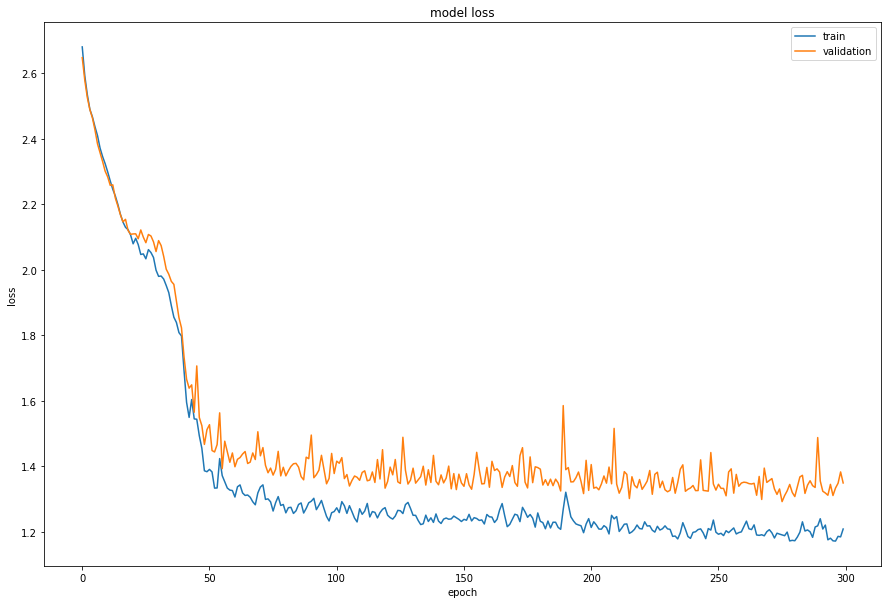

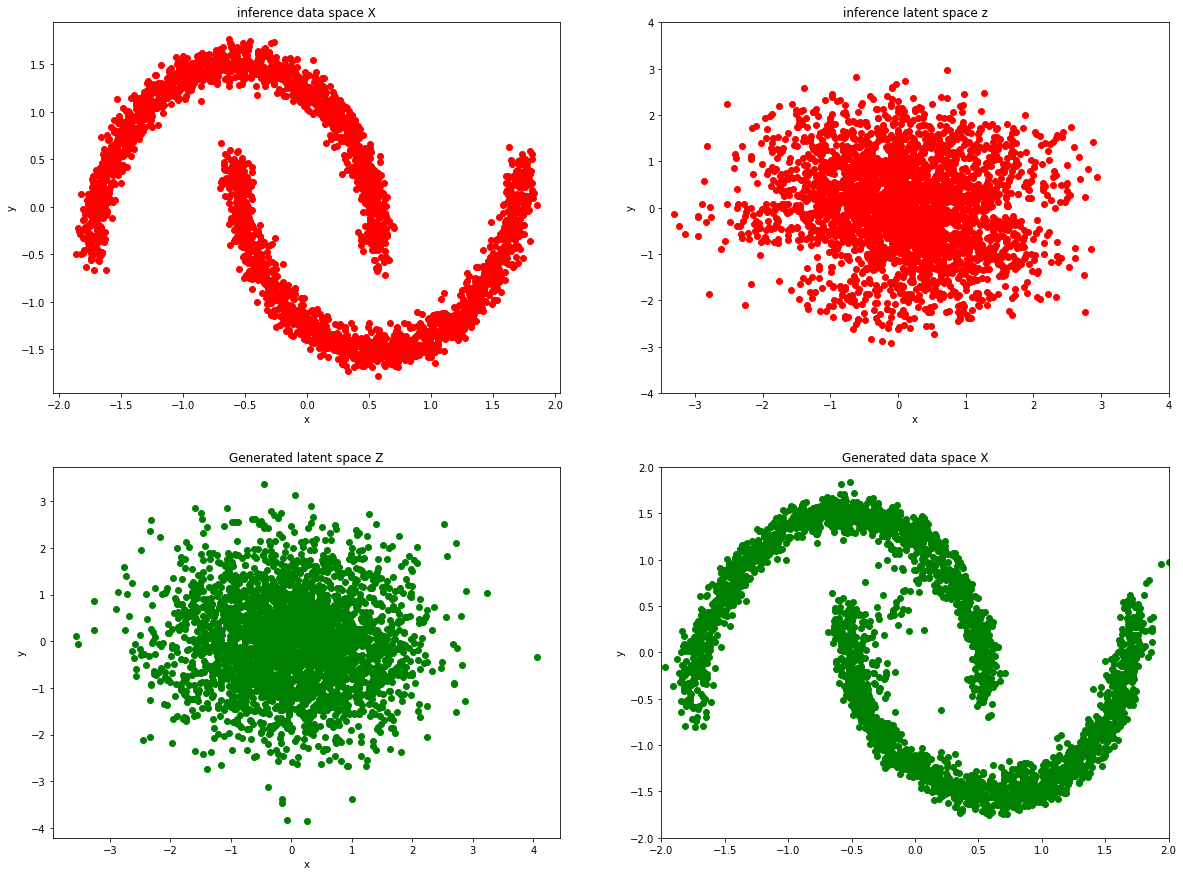

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

z, _ = model(normalized_data)

samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="inference latent space z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="X", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])

# Project 74

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import os
import re
import string
import random

In [40]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)
    return tf.tile(mask, mult)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim), ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [41]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [45]:
vocab_size = 20000
maxlen = 80
embed_dim = 256
num_heads = 2
feed_forward_dim = 256

def create_model():
    inputs = layers.Input(shape=(maxlen, ), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile("adam", loss=[loss_fn, None])
    return model

In [37]:
batch_size = 128
filenames = []
directories = [
    "aclImdb/train/pos",
    "aclImdb/train/neg",
    "aclImdb/test/pos",
    "aclImdb/test/neg",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))
print(f"{len(filenames)} files")
random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

def custom_standardization(input_string):
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", "\1")

vectorize_layer = TextVectorization(standardize=custom_standardization, max_tokens=vocab_size-1, 
                                    output_mode="int", output_sequence_length=maxlen + 1)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

def prepare_lm_inputs_labels(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y
text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

50000 files


In [46]:
class TextGenerator(keras.callbacks.Callback):
    def __init__(self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dim(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)
    def detokenize(self, number):
        return self.index_to_word[number]
    def on_epoch_End(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_tokens)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join([self.detokenize(_) for _ in self.start_tokens + tokens_generated])
        print(f"generated text: \n{txt}\n")
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

start_prompt = "this movie is"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 40
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

In [47]:
model = create_model()
model.fit(text_ds, verbose=2, epochs=25, callbacks=[text_gen_callback])

Epoch 1/25
391/391 - 2203s - loss: 5.7618 - dense_198_loss: 5.7618 - 2203s/epoch - 6s/step
Epoch 2/25
391/391 - 1624s - loss: 4.9440 - dense_198_loss: 4.9440 - 1624s/epoch - 4s/step
Epoch 3/25
391/391 - 1588s - loss: 4.6896 - dense_198_loss: 4.6896 - 1588s/epoch - 4s/step
Epoch 4/25
391/391 - 1584s - loss: 4.5235 - dense_198_loss: 4.5235 - 1584s/epoch - 4s/step
Epoch 5/25
391/391 - 1587s - loss: 4.3943 - dense_198_loss: 4.3943 - 1587s/epoch - 4s/step
Epoch 6/25
391/391 - 1591s - loss: 4.2887 - dense_198_loss: 4.2887 - 1591s/epoch - 4s/step
Epoch 7/25
391/391 - 1594s - loss: 4.1995 - dense_198_loss: 4.1995 - 1594s/epoch - 4s/step
Epoch 8/25
391/391 - 1595s - loss: 4.1216 - dense_198_loss: 4.1216 - 1595s/epoch - 4s/step
Epoch 9/25
391/391 - 1589s - loss: 4.0541 - dense_198_loss: 4.0541 - 1589s/epoch - 4s/step
Epoch 10/25
391/391 - 1594s - loss: 3.9936 - dense_198_loss: 3.9936 - 1594s/epoch - 4s/step
Epoch 11/25
391/391 - 1593s - loss: 3.9391 - dense_198_loss: 3.9391 - 1593s/epoch - 4s/st

# Project 75

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [49]:
class VectorQuantize(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (beta)
        
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(initial_value=w_init(shape=(self.embedding_dim, self.num_embeddings), 
                                                        dtype="float32"), trainable=True, name="embedding_vqbae")
    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)
        
        comitment_loss = self.beta * tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(comitment_loss + codebook_loss)
        
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized
    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
                     + tf.reduce_sum(self.embeddings ** 2) - 2 * similarity)
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [53]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")
def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(latent_inputs)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [55]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantize(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")
get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntize)                                                          
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [60]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        
        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")
    @property
    def metrics(self):
        return [
            self.total_loss_tracker, 
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker
        ]
    def train_step(self, x):
        with tf.GradientTape() as tape:
            reconstructions = self.vqvae(x)
            reconstruction_loss = (tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)
            
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))
        return {
            "loss":self.total_loss_tracker.result(), 
            "reconstruction_loss":self.reconstruction_loss_tracker.result(),
            "vqvae_loss":self.vq_loss_tracker.result()
        }

In [61]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5
data_variance = np.var(x_train / 255.0)

In [62]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 70s 145ms/step - loss: 2.6109 - reconstruction_loss: 0.3488 - vqvae_loss: 1.9702
Epoch 2/30
469/469 [==============================] - 68s 144ms/step - loss: 3.2368 - reconstruction_loss: 0.1811 - vqvae_loss: 3.0531
Epoch 3/30
469/469 [==============================] - 68s 145ms/step - loss: 2.6758 - reconstruction_loss: 0.2011 - vqvae_loss: 2.4845
Epoch 4/30
469/469 [==============================] - 68s 145ms/step - loss: 2.9360 - reconstruction_loss: 0.2307 - vqvae_loss: 2.7101
Epoch 5/30
469/469 [==============================] - 68s 145ms/step - loss: 2.7027 - reconstruction_loss: 0.2533 - vqvae_loss: 2.4547
Epoch 6/30
469/469 [==============================] - 68s 145ms/step - loss: 2.9855 - reconstruction_loss: 0.2405 - vqvae_loss: 2.7285
Epoch 7/30
469/469 [==============================] - 68s 146ms/step - loss: 1.6851 - reconstruction_loss: 0.1913 - vqvae_loss: 1.4895
Epoch 8/30
469/469 [==============================] - 6

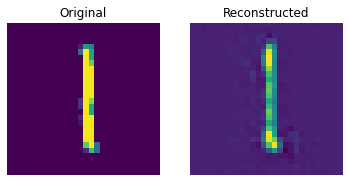

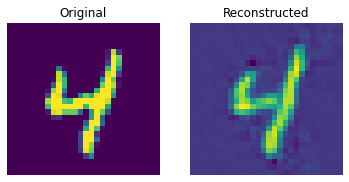

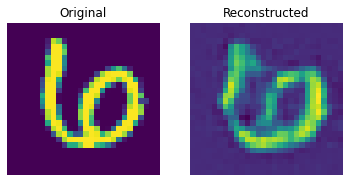

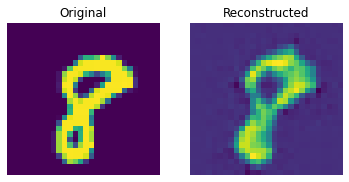

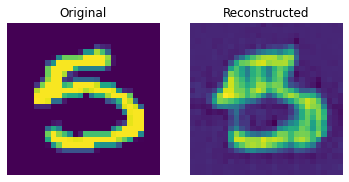

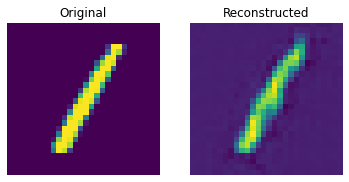

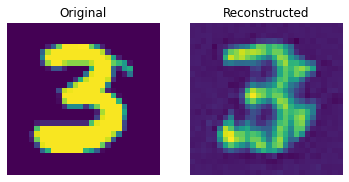

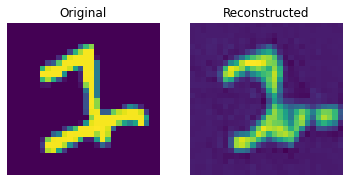

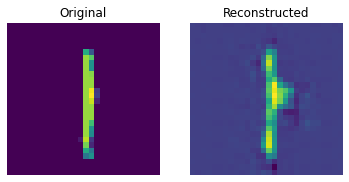

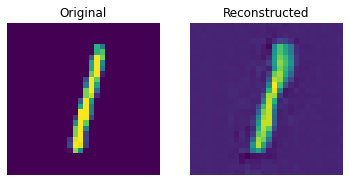

In [65]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")
    plt.show()
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructed_test = trained_vqvae_model.predict(test_images)
for test_image, reconstructed_image in zip(test_images, reconstructed_test):
    show_subplot(test_image, reconstructed_image)

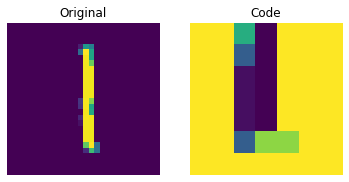

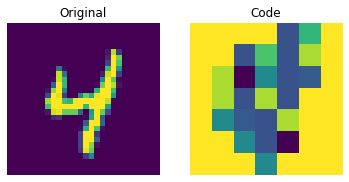

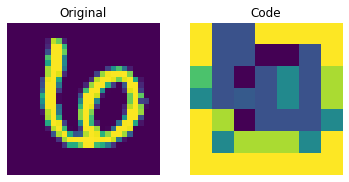

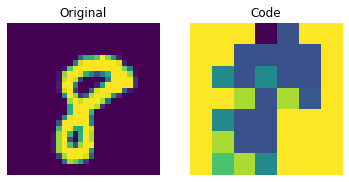

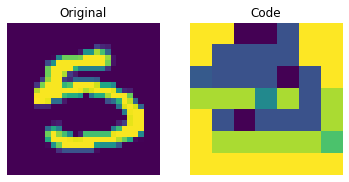

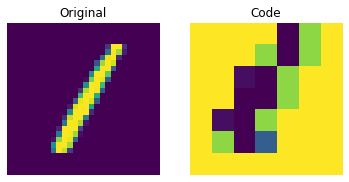

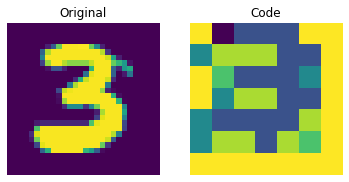

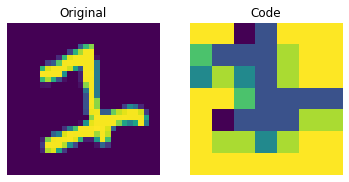

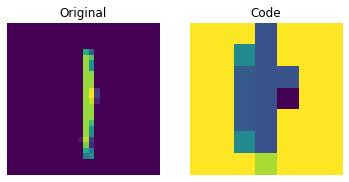

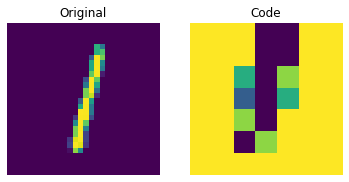

In [68]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [71]:
num_residual_blocks = 2
num_pixelcnn_layers = 2
pixelcnn_input_shape = encoded_outputs.shape[1:-1]
print(f"Input shape of the PixelCNN: {pixelcnn_input_shape}")
class PixelConvLayer(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(PixelConvLayer, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)
    def build(self, input_shape):
        self.conv.build(input_shape)
        
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

class ResidualBlock(keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = keras.layers.Conv2D(filters=filters, kernel_size=1, activation="relu")
        self.pixel_conv = PixelConvLayer(mask_type="B", filters=filters // 2, kernel_size=3, activation="relu", 
                                        padding="same")
        self.conv2 = keras.layers.Conv2D(filters=filters, kernel_size=1, activation="relu")
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return keras.layers.add([inputs, x])
    
pixelcnn_inputs = keras.Input(shape=pixelcnn_input_shape, dtype=tf.int32)
ohe = tf.one_hot(pixelcnn_inputs, vqvae_trainer.num_embeddings)
x = PixelConvLayer(mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same")(ohe)

for _ in range(num_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(num_pixelcnn_layers):
    x = PixelConvLayer(mask_type="B", filters=128, kernel_size=1, strides=1, activation="relu", padding="valid")(x)

out = keras.layers.Conv2D(filters=vqvae_trainer.num_embeddings, kernel_size=1, strides=1, padding="same")(x)
pixel_cnn = keras.Model(pixelcnn_inputs, out, name="pixel_cnn")
pixel_cnn.summary()

Input shape of the PixelCNN: (7, 7)
Model: "pixel_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 7, 7)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, 7, 7, 128)         0         
                                                                 
 pixel_conv_layer (PixelConv  (None, 7, 7, 128)        802944    
 Layer)                                                          
                                                                 
 residual_block (ResidualBlo  (None, 7, 7, 128)        98624     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 7, 7, 128)        98624     
 lock)                                                           
                     

In [72]:
encoded_outputs = encoder.predict(x_train_scaled)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)

codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(f"Shape of the training data for PixelCNN: {codebook_indices.shape}")

Shape of the training data for PixelCNN: (60000, 7, 7)


In [73]:
pixel_cnn.compile(optimizer=keras.optimizers.Adam(3e-4), 
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
pixel_cnn.fit(x = codebook_indices, y=codebook_indices, batch_size=128, epochs=30, validation_split=0.1)

Epoch 1/30
422/422 [==============================] - 199s 465ms/step - loss: 1.1664 - accuracy: 0.6688 - val_loss: 0.7372 - val_accuracy: 0.7365
Epoch 2/30
422/422 [==============================] - 195s 463ms/step - loss: 0.6869 - accuracy: 0.7510 - val_loss: 0.6635 - val_accuracy: 0.7579
Epoch 3/30
422/422 [==============================] - 195s 463ms/step - loss: 0.6469 - accuracy: 0.7633 - val_loss: 0.6379 - val_accuracy: 0.7675
Epoch 4/30
422/422 [==============================] - 195s 463ms/step - loss: 0.6292 - accuracy: 0.7693 - val_loss: 0.6263 - val_accuracy: 0.7703
Epoch 5/30
422/422 [==============================] - 195s 463ms/step - loss: 0.6189 - accuracy: 0.7725 - val_loss: 0.6158 - val_accuracy: 0.7745
Epoch 6/30
422/422 [==============================] - 195s 463ms/step - loss: 0.6106 - accuracy: 0.7752 - val_loss: 0.6110 - val_accuracy: 0.7765
Epoch 7/30
422/422 [==============================] - 195s 462ms/step - loss: 0.6053 - accuracy: 0.7768 - val_loss: 0.6054 -

# Project 76